## mQTLs detected on raw data

So far I have detected QTLs on the log2 transformed data. This was done to make the phenotype values (metabolite measurements) follow a normal distribution, which is an important assumption made by QTL detection methods in rQTL. See notebook re: [distribution of metabolite data](http://nbviewer.jupyter.org/github/scalefreegan/steinmetz-lab/blob/master/genphen/notebooks/Metabolite_normality.ipynb)

Very few QTLs are detected on log2 transformed data.

Paul Jung asks whether log2 transformation compromises ability to detect QTLs.

Here I look for mQTLs in raw data

**Conlcusion:** QTLs detected on raw or log2 data do not differ dramatically. However, there are several differences to note. See QTL interval table below. 

### Run stuff

In [3]:
.libPaths("~/R/x86_64-redhat-linux-gnu-library/3.2/")
# config opts and libraries
options(repr.plot.width = 6)
options(repr.plot.height = 5)
options(jupyter.plot_mimetypes = 'image/png')
library(ggplot2);
library(plyr);
library(dplyr);
library(reshape2);
library(LSD);
library(qtl);
library(pheatmap);
library(funqtl);
library(parallel);
options(mc.cores = 24);
library(snow);
library(igraph);
library(stringr);
library(RColorBrewer);
library(jpeg);

# source rQTL utilities
devtools::source_url("https://raw.githubusercontent.com/scalefreegan/steinmetz-lab/master/QTL/rQTL.R")

SHA-1 hash of file is 5dfc0f3e6aa1c2f849de825db2c0588ff5aa9736


In [4]:
# load data
endo_f = "/g/steinmetz/project/GenPhen/data/endometabolome/data/endometabolite_full_12102015.rda"
load(endo_f)
#head(endometabolite)

In [5]:
# load genotype and markers files
genotype_f = "/g/steinmetz/brooks/yeast/genomes/S288CxYJM789/genotypes_S288c_R64.rda"
load(genotype_f)

In [6]:
# limit data to relative time format
endometabolite_relative = endometabolite %>% filter(., time_format == "relative")
mPhen = acast(data = endometabolite_relative, formula = metabolite + time ~ strain, 
              value.var="value", fun.aggregate = mean)
#head(mPhen)

In [7]:
# Only run QTL detection if corresponding file does not exist
f = "/g/steinmetz/brooks/genphen/metabolome/qtls/mQTLs_funqtl_raw.rda"
if (!file.exists(f)) {
    # QTLs
    pheno = mPhen
    cross = runQTL(
                genotype = geno,
                phenotype = t(pheno),
                marker_info = mrk,
                return_cross = TRUE,
                estimate.map = FALSE
                )
    rep2metabolites = sapply(rownames(pheno), function(i) {
        o = strsplit(i,"_")[[1]][1]
        return(o)
    })
    # first detect qtls individually
    # have to run funqtl for each metabolite
    # as shortcut, just replace cross object phenotypes
    # for each metabolite
    pb = txtProgressBar(min = 0, max = length(unique(rep2metabolites)), style = 3)
    mQTLs_funqtl_raw = mclapply(1:length(unique(rep2metabolites)), function(i) {
        try({
            m = unique(rep2metabolites)[i]
            setTxtProgressBar(pb, i)
            these_phe = c(names(which(rep2metabolites == m)),"id")
            cross_tmp = cross
            cross_tmp$pheno = cross_tmp$pheno[,these_phe]
            colnames(cross_tmp$pheno) = c(sapply(colnames(cross_tmp$pheno), function(i){
                o = strsplit(i, split = "_")[[1]][2]
                if (is.na(o)) {
                    o = "id"
                }
                return(o)
                }))
            cross_tmp = calc.genoprob(cross_tmp, step = 0)
            # last phenotype column is the "id" tag
            pcols = seq(1, length(these_phe) - 1)
            qtls = scanone(cross_tmp, method = "hk",pheno.col = pcols)
            eff = geteffects(cross_tmp, pheno.col = pcols)
            qtls_alt = scanoneF(cross_tmp, pheno.cols = pcols, method = "hk")
            # calc permutation threshold
            permout = scanoneF(cross_tmp, pheno.cols = pcols,
                                method = "hk", n.perm = 1000, n.cluster = 20, verbose = F)
            # identify chrs with slod/lod above permute val
            chrs = unique(c(
                qtls_alt[qtls_alt[,"slod"]>=summary(permout)["5%","slod"],"chr"],
                qtls_alt[qtls_alt[,"mlod"]>=summary(permout)["5%","mlod"],"chr"]
                )
            )
            qtl_intervals = list()
            if (length(chrs)>0) {
                for (i in chrs) {
                    qtl_intervals[[as.character(i)]] = 
                    mrk[rownames(bayesint(qtls_alt, chr = str_pad(i, 2, pad = "0"), prob=0.95, lodcolumn=1))]
                }
            }
            return(list(qtls = qtls, eff = eff,
                qtls_alt = qtls_alt, qtl_intervals = qtl_intervals,
                permout = permout, pcols = pcols))
        })
    })
    names(mQTLs_funqtl_raw)  = unique(rep2metabolites)
    save(mQTLs_funqtl_raw , file = f)
    close(pb)
} else {
    load(f)
}

## RESULTS

## Comparison of QTLs on raw and normalized data

By eye they look similar. For a more quantitative comparison I computed sig QTLs and LOD correlations

In [8]:
# load normalized QTLs
load("/g/steinmetz/brooks/genphen//metabolome/qtls/mQTLs_comball_funqtl_2014.rda")

Compute intervals

In [11]:
type = "mlod"
co = .1 # 10% FDR
bayesint = .95 # 95% Bayesian confidence interval around QTL

# normalized data
data = mQTLs_funqtl_2014
qtls_norm = do.call(rbind,lapply(names(data), function(i){
    o = try({
    #print(i)
    m = i
    type = type
    chrs = unique(data[[m]]$qtls_alt[data[[m]]$qtls_alt[,type]>=summary(data[[m]]$permout[,type],co)[1],"chr"])
    chrs = levels(chrs)[chrs]
    lodcolumn = if(type=="mlod"){ 2 } else { 1 }
    qtl_intervals = list()
    if (length(chrs)>0) {
      for (i in chrs) {
        qtl_intervals[[i]] = try(mrk[rownames(bayesint(data[[m]]$qtls_alt, 
                                                       chr = str_pad(i, 2, pad = "0"), 
                                                       prob=bayesint, lodcolumn=lodcolumn))],silent = T)
        if (class(qtl_intervals[[i]])=="try-error") {
          qtl_intervals[[i]] = NULL
        } else {
          nn = sapply(as.character(seqnames(qtl_intervals[[i]])),function(i){
            paste(substr(i,1,3),as.roman(substr(i,4,5)),sep="")
          })
          qtl_intervals[[i]] = renameSeqlevels(qtl_intervals[[i]],nn)
          qtl_intervals[[i]] = keepSeqlevels(qtl_intervals[[i]],unique(nn))
          qtl_intervals[[i]] = range(qtl_intervals[[i]])
        }
      }
    }
    if (length(qtl_intervals) > 1) {
        qtl_df = do.call(rbind,qtl_intervals)
    } else {
        qtl_df = as.data.frame(qtl_intervals[[1]])
    }
    qtl_df = cbind(metabolite = m, qtl_df)
    })
    if (class(o)!="try-error") {
        return(o)
    } else {
        return(NULL)
    }
}))

# raw data
data = mQTLs_funqtl_raw
qtls_raw = do.call(rbind,lapply(names(data), function(i){
    o = try({
    #print(i)
    m = i
    type = type
    chrs = unique(data[[m]]$qtls_alt[data[[m]]$qtls_alt[,type]>=summary(data[[m]]$permout[,type],co)[1],"chr"])
    chrs = levels(chrs)[chrs]
    lodcolumn = if(type=="mlod"){ 2 } else { 1 }
    qtl_intervals = list()
    if (length(chrs)>0) {
      for (i in chrs) {
        qtl_intervals[[i]] = try(mrk[rownames(bayesint(data[[m]]$qtls_alt, 
                                                       chr = str_pad(i, 2, pad = "0"), 
                                                       prob=bayesint, lodcolumn=lodcolumn))],silent = T)
        if (class(qtl_intervals[[i]])=="try-error") {
          qtl_intervals[[i]] = NULL
        } else {
          nn = sapply(as.character(seqnames(qtl_intervals[[i]])),function(i){
            paste(substr(i,1,3),as.roman(substr(i,4,5)),sep="")
          })
          qtl_intervals[[i]] = renameSeqlevels(qtl_intervals[[i]],nn)
          qtl_intervals[[i]] = keepSeqlevels(qtl_intervals[[i]],unique(nn))
          qtl_intervals[[i]] = range(qtl_intervals[[i]])
        }
      }
    }
    if (length(qtl_intervals) > 1) {
        qtl_df = do.call(rbind,qtl_intervals)
    } else {
        qtl_df = as.data.frame(qtl_intervals[[1]])
    }
    qtl_df = cbind(metabolite = m, qtl_df)
    })
    if (class(o)!="try-error") {
        return(o)
    } else {
        return(NULL)
    }
}))

### Normalized Data QTLs

Significant QTL intervals detected in the log2 normalized data

In [12]:
qtls_norm
#save(qtls_norm, file = "/g/steinmetz/brooks/genphen/metabolome/qtls/mQTLs_table.rda")

,metabolite,seqnames,start,end,width,strand
1,AKG,chrXIII,24134,169765,145632,*
2,ASP,chrIV,570106,1517334,947229,*
3,GLN,chrVII,199690,291925,92236,*
4,GLY,chrXIII,24997,150534,125538,*
5,HSE,chrXIII,24474,114648,90175,*
6,LEU,chrXIII,43096,168686,125591,*
7,MET,chrXIII,77482,146198,68717,*
8,PHE,chrXV,982135,1020567,38433,*
9,PYR,chrXIII,45947,168229,122283,*
10,TRP,chrXIII,869798,917493,47696,*


### Raw Data QTLs

Significant QTL intervals detected in the raw data

In [142]:
qtls_raw

,metabolite,seqnames,start,end,width,strand
1,AKG,chrXIII,38166,169765,131600,*
2,PYR,chrXIII,51951,168139,116189,*
3,ALA,chrXIII,22768,912626,889859,*
4,ASP,chrIV,288429,1517334,1228906,*
5,GLU,chrXIII,75304,168229,92926,*
6,GLY,chrXIII,25025,169412,144388,*
7,HSE,chrXIII,26434,152033,125600,*
8,LEU,chrXIII,96832,168229,71398,*
9,MET,chrXIII,75396,169814,94419,*
10,PHE,chrIV,61995,1387436,1325442,*


### LOD correlations

In [1]:
LODcorrelation = do.call(c,lapply(names(mQTLs_funqtl_2014),function(i){
    o = try({
        do.call(c, lapply(c("1","2","3","4"), function(j){
            cor(mQTLs_funqtl_2014[[i]]$qtls[,j],mQTLs_funqtl_raw[[i]]$qtls[,j],
                use = "complete", method = "spearman")
        }))
    })
    if (class(o)!="try-error") {
        return(as.numeric(o))
    } else {
        return(NULL)
    }
}))

ERROR: Error in lapply(names(mQTLs_funqtl_2014), function(i) {: object 'mQTLs_funqtl_2014' not found


In [2]:
hist(LODcorrelation, main = "Raw vs. Normalized data LOD corr all timepoint pairs", 
     xlim = c(0,1), xlab = "Spearman correlation")

ERROR: Error in hist(LODcorrelation, main = "Raw vs. Normalized data LOD corr all timepoint pairs", : object 'LODcorrelation' not found


## QTL plots for raw data QTLs

### LOD Plots

**SLOD**: Average LOD score across 4 timepoints

**MLOD**: Maximum LOD score across 4 timepoints 

Warning message:
In eval(expr, envir, enclos): NAs introduced by coercionWarning message:
In eval(expr, envir, enclos): NAs introduced by coercion

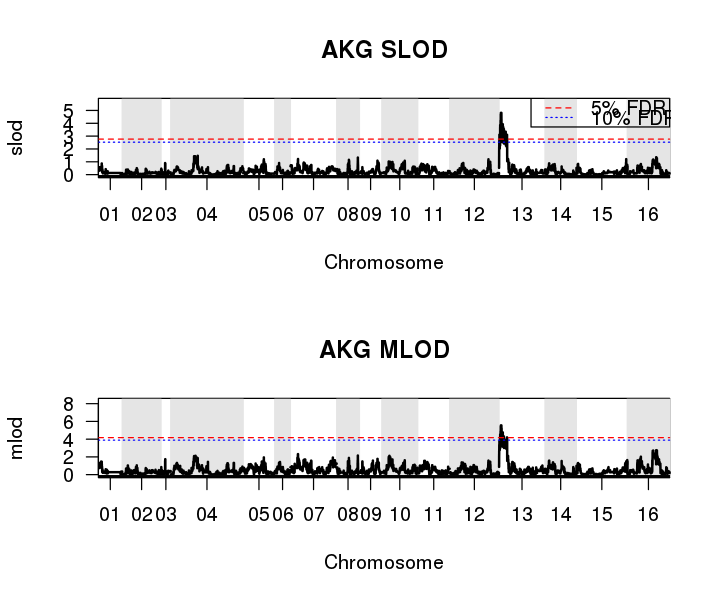

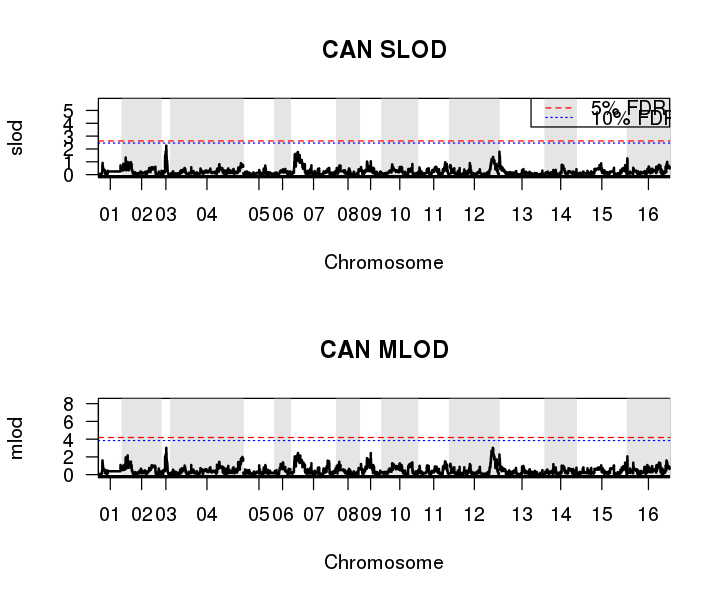

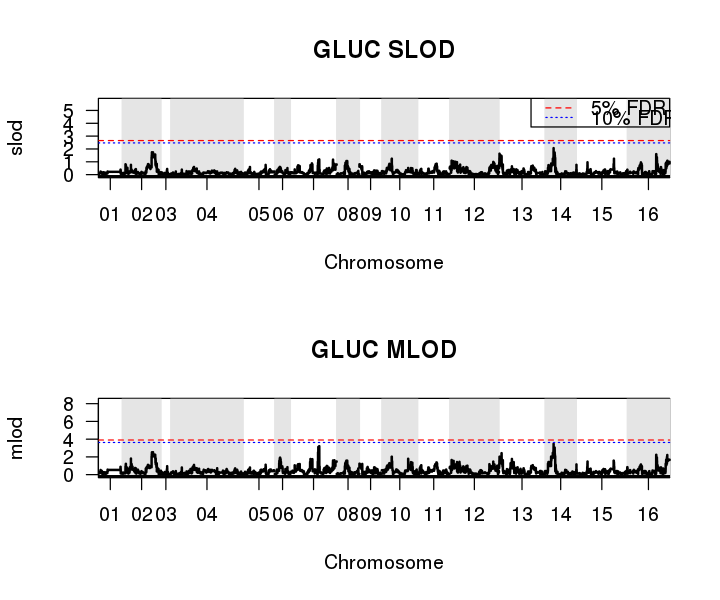

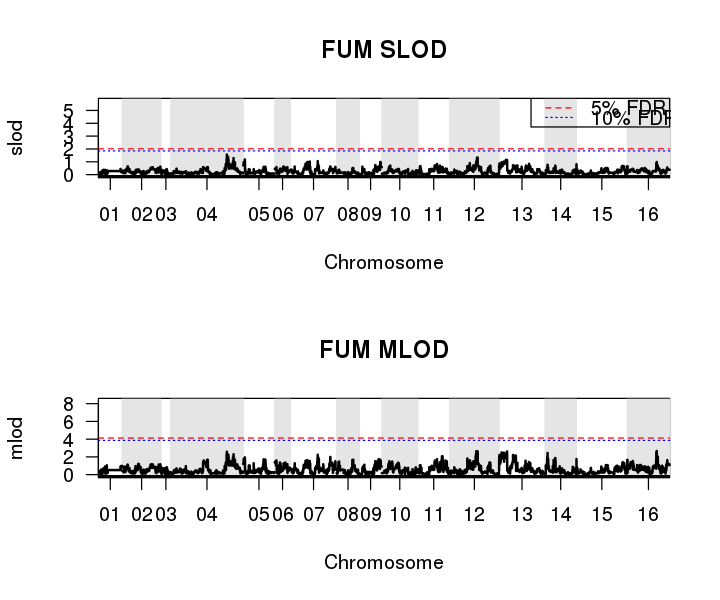

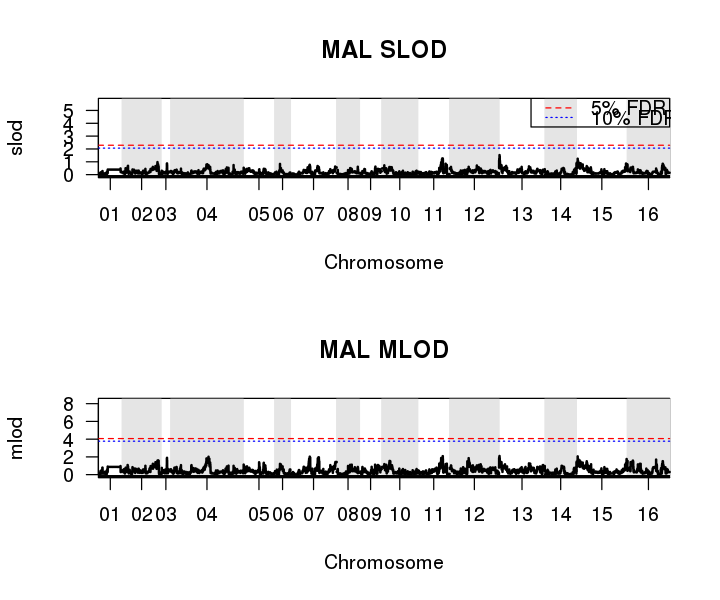

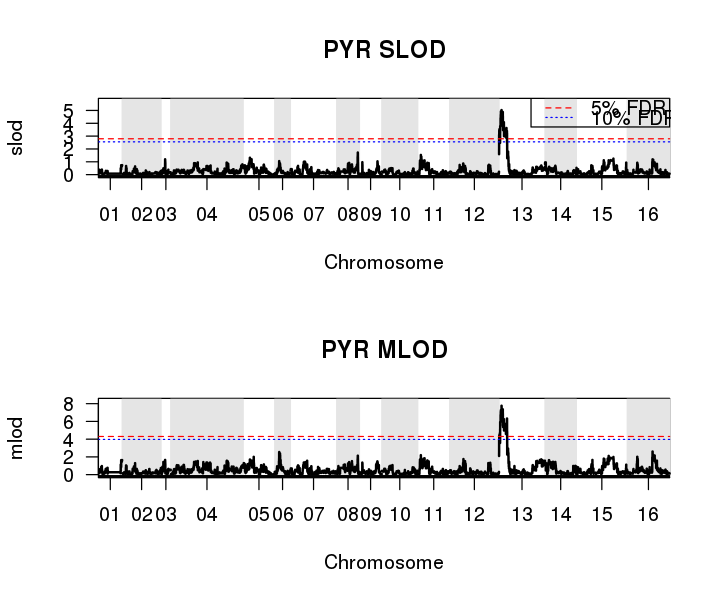

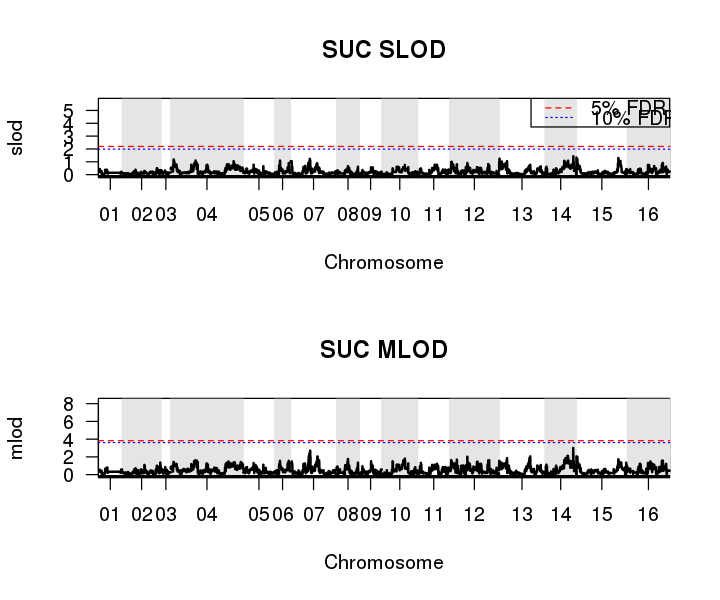

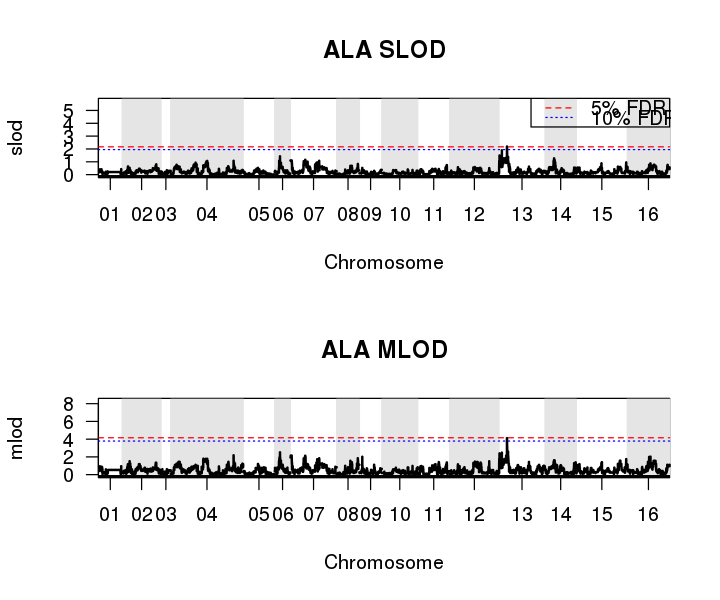

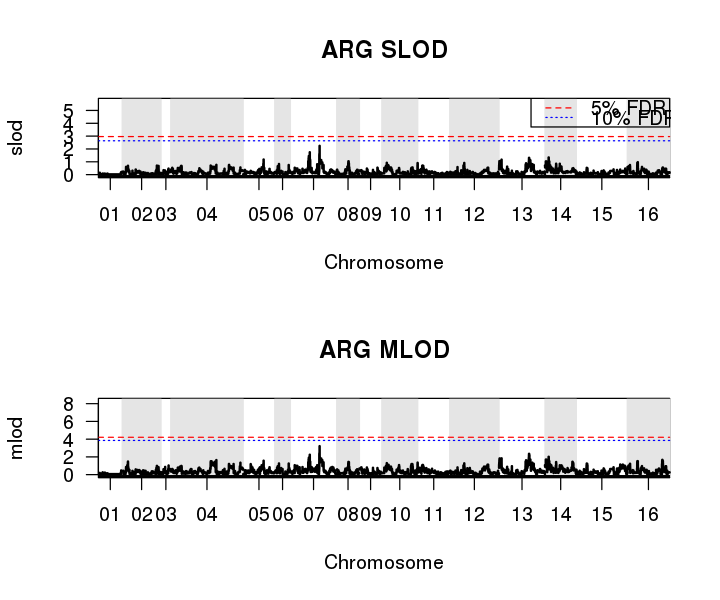

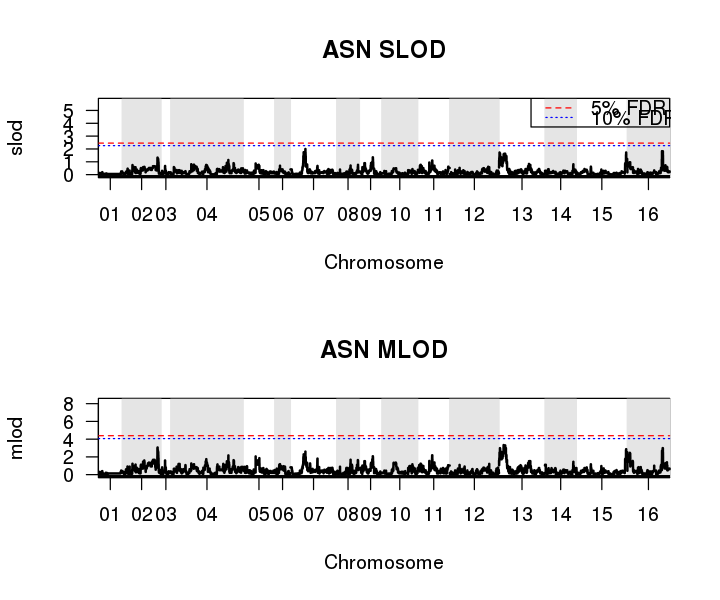

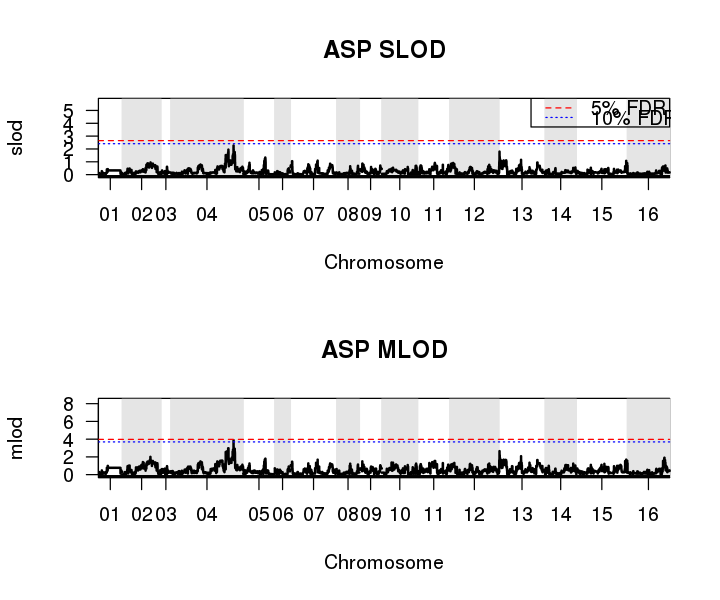

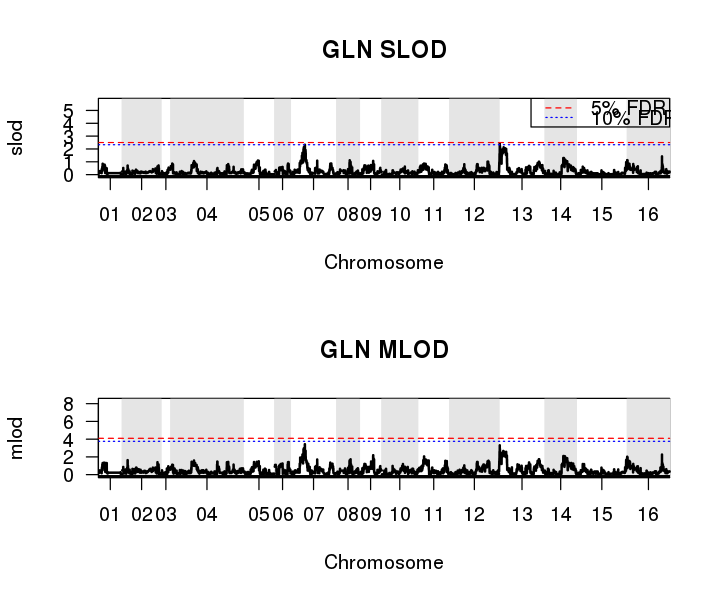

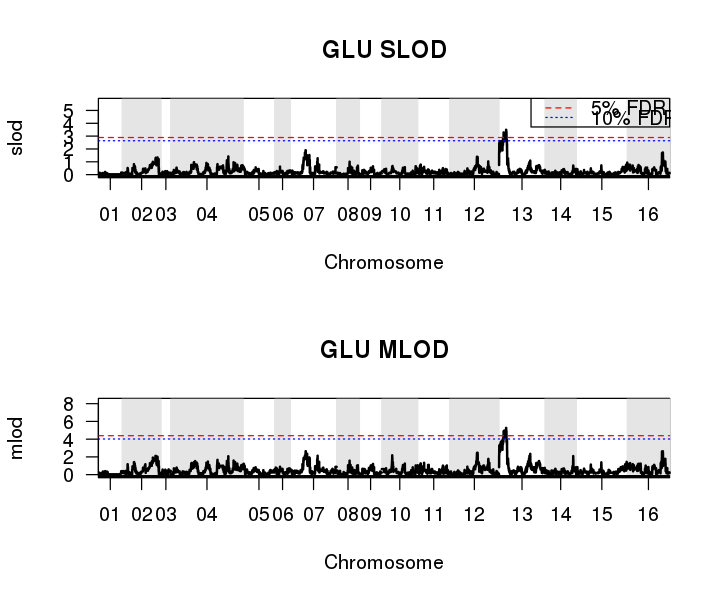

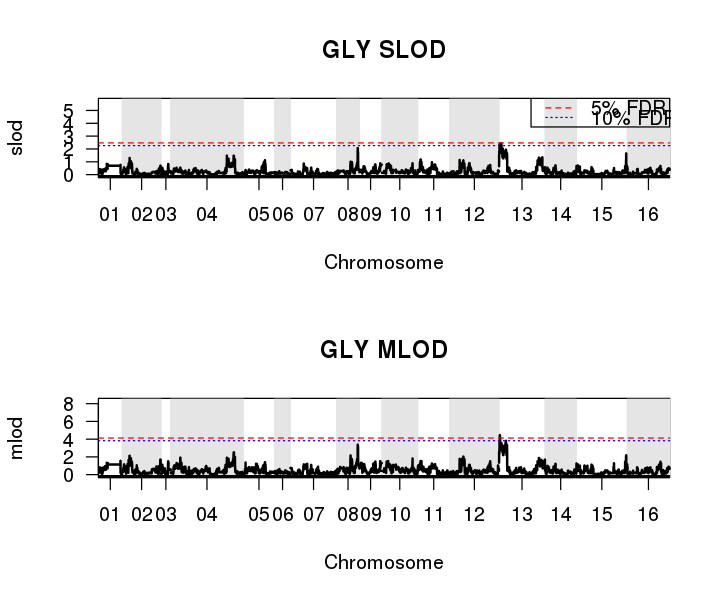

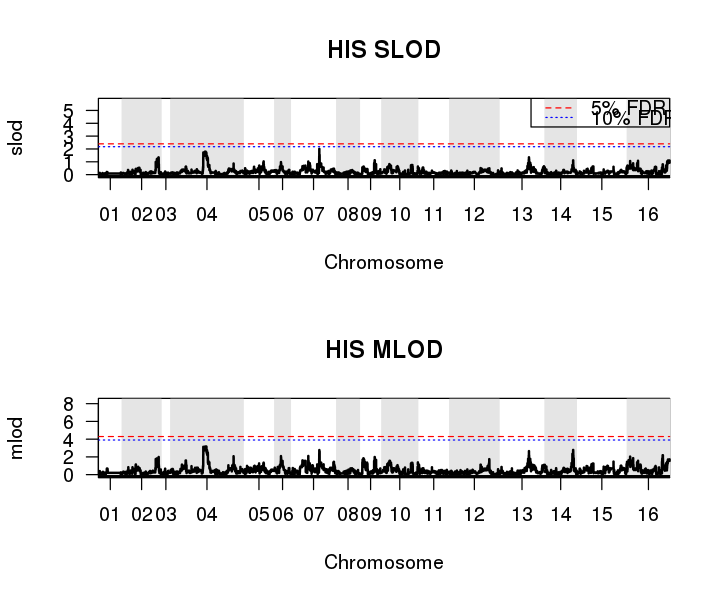

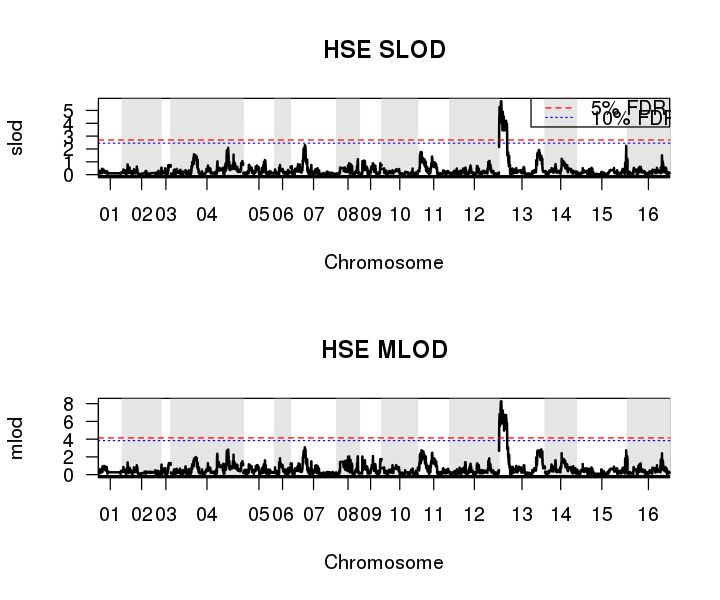

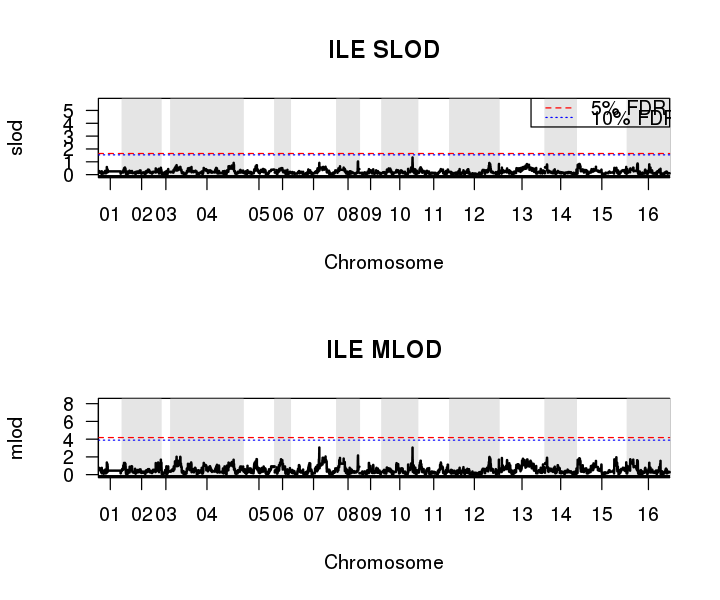

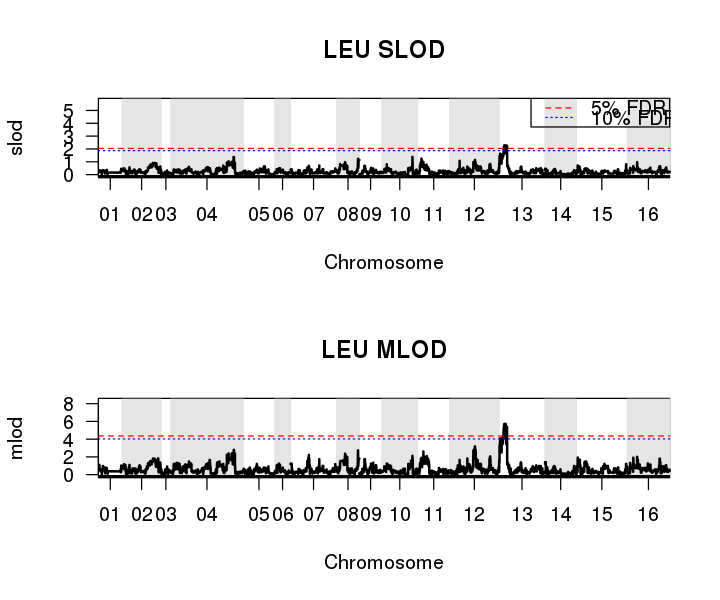

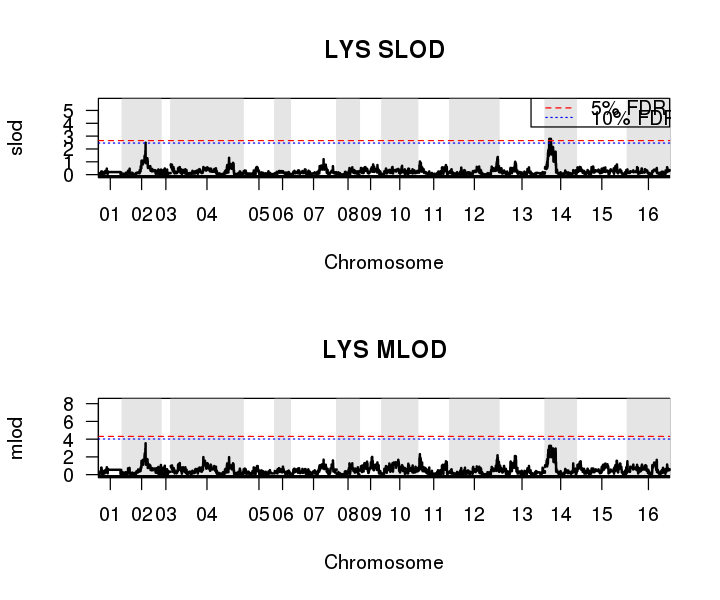

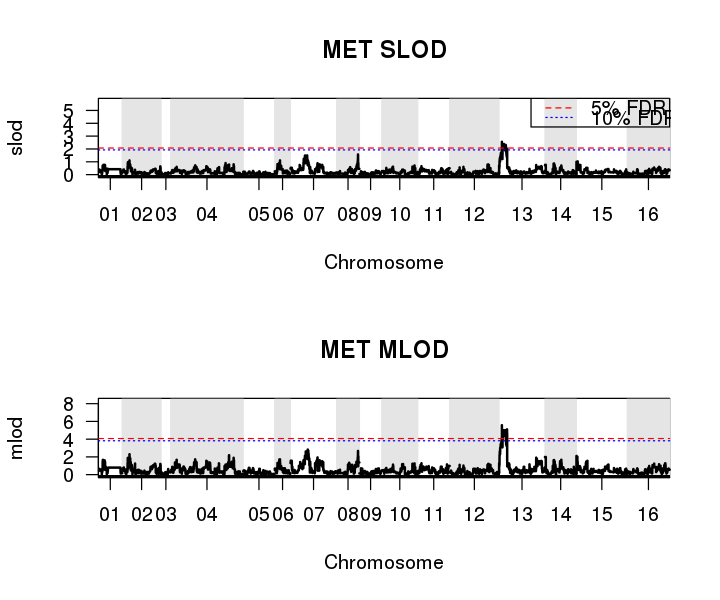

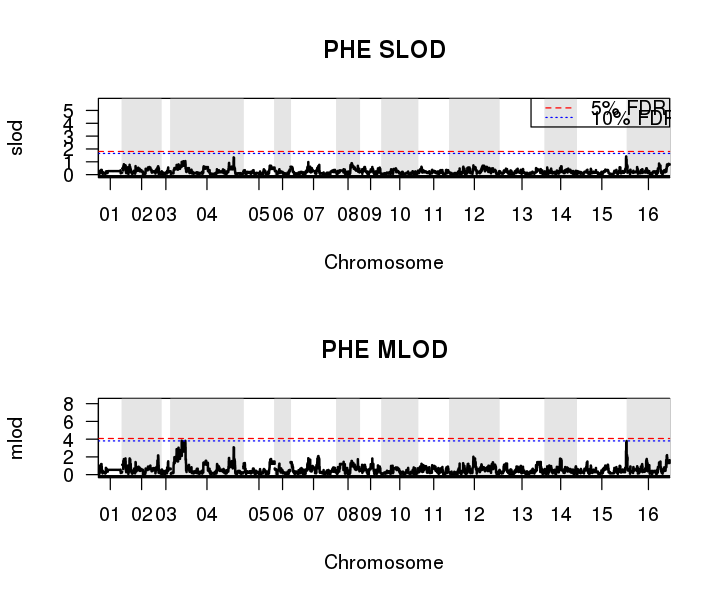

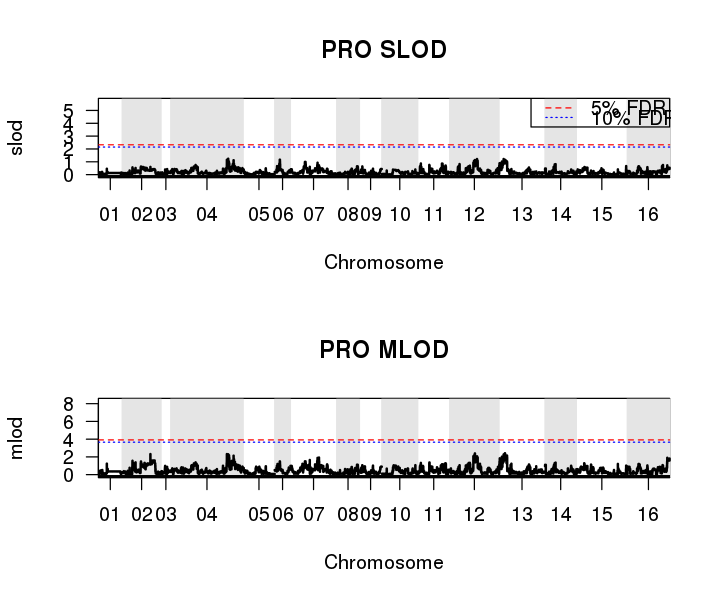

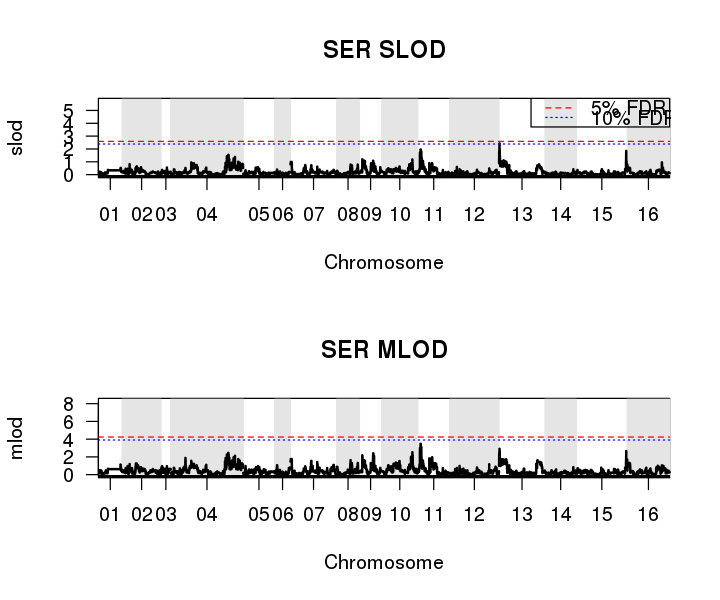

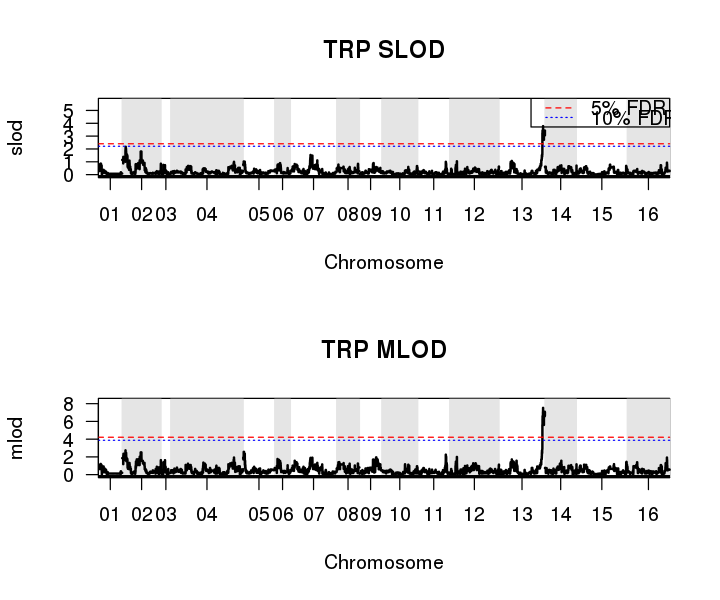

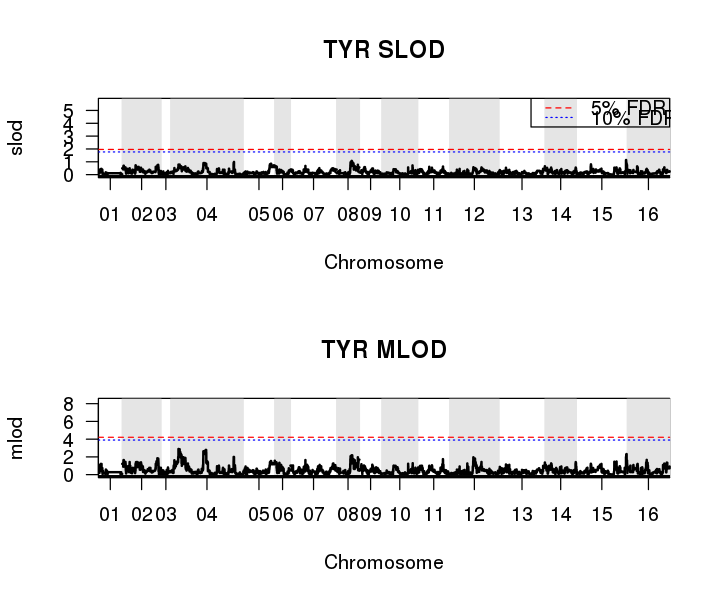

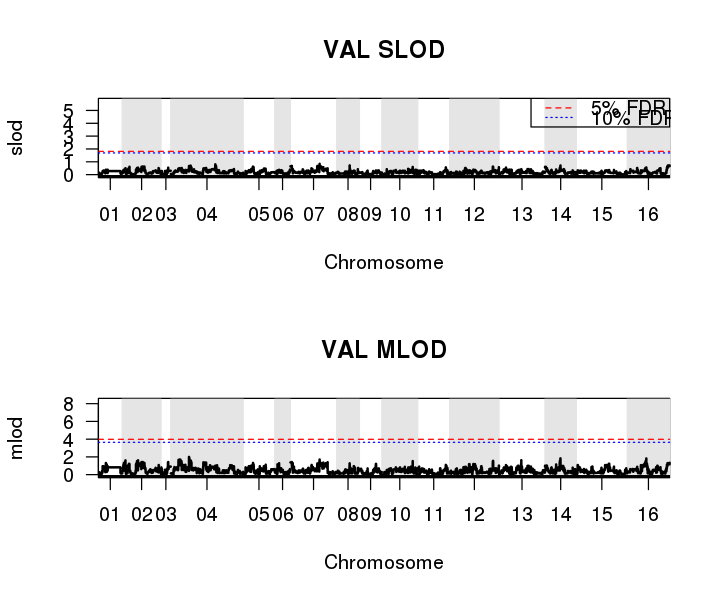

In [18]:
m_slod = max(as.numeric(unlist(lapply(seq(1:length(mQTLs_funqtl_raw)),
                                          function(i){try(max(mQTLs_funqtl_raw[[i]]$qtls_alt[,'slod']))}))), na.rm = T)
m_mlod = max(as.numeric(unlist(lapply(seq(1:length(mQTLs_funqtl_raw)),
                                      function(i){try(max(mQTLs_funqtl_raw[[i]]$qtls_alt[,'mlod']))}))), na.rm = T)

# lod plots
for (i in 1:length(mQTLs_funqtl_raw)) {
    try({
        par(mfrow=c(2,1))
        plot(mQTLs_funqtl_raw[[i]]$qtls_alt, ylim=c(0,m_slod), main=paste(names(mQTLs_funqtl_raw)[i],"SLOD"),bandcol="gray90")
        abline(h=summary(mQTLs_funqtl_raw[[i]]$permout)["5%","slod"], col="red", lty=2)
        abline(h=summary(mQTLs_funqtl_raw[[i]]$permout)["10%","slod"], col="blue", lty=3)
        legend("topright", y.leg[i], c("5% FDR","10% FDR"), lty = c(2, 3), col = c("red","blue"))
        plot(mQTLs_funqtl_raw[[i]]$qtls_alt, lodcolumn=2, ylim=c(0,m_mlod),
                main=paste(names(mQTLs_funqtl_raw)[i],"MLOD"), bandcol="gray90")
        abline(h=summary(mQTLs_funqtl_raw[[i]]$permout)["5%","mlod"], col="red", lty=2)
        abline(h=summary(mQTLs_funqtl_raw[[i]]$permout)["10%","mlod"], col="blue", lty=3)
    })
}

### Effect Plots

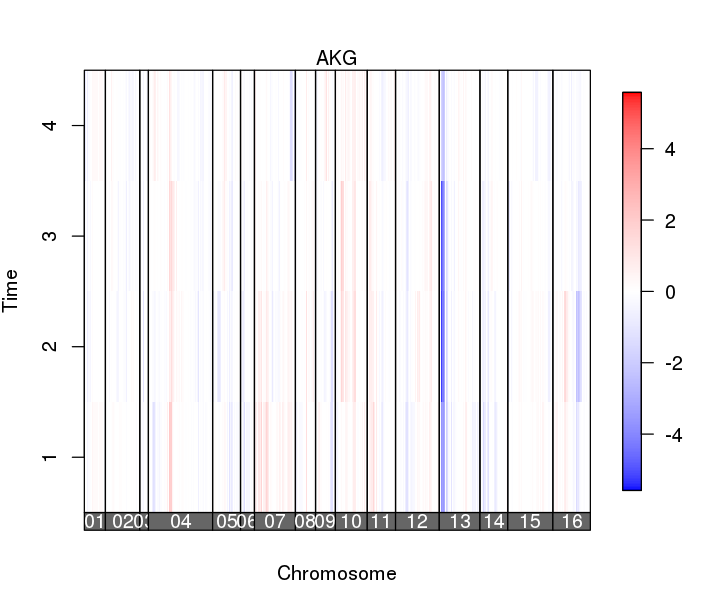

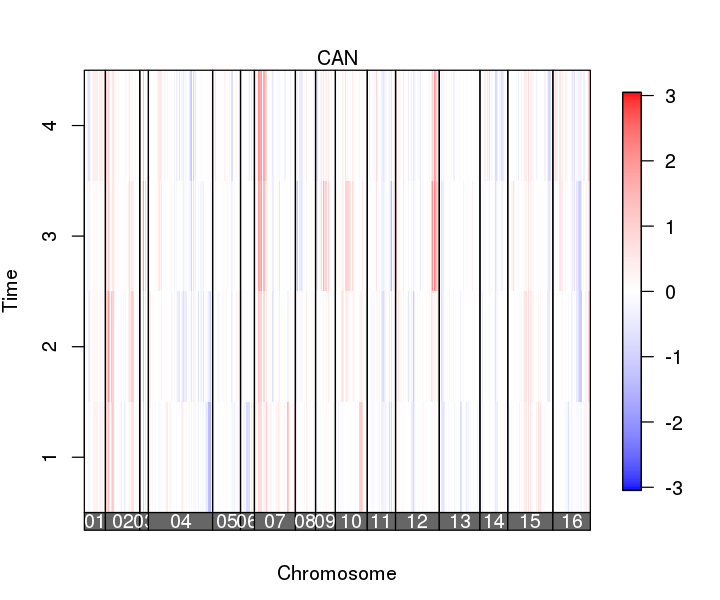

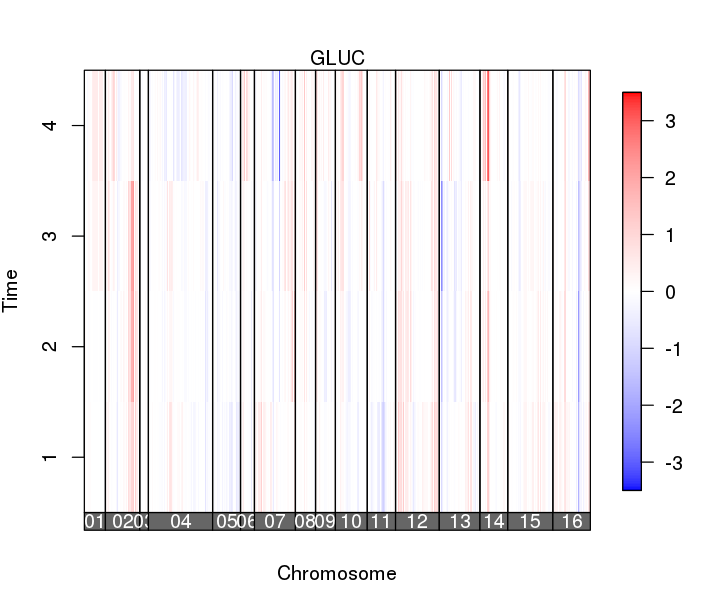

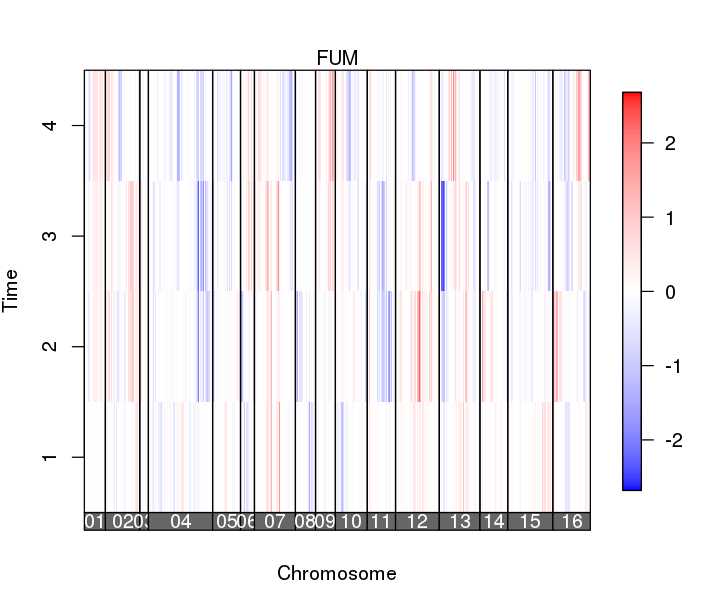

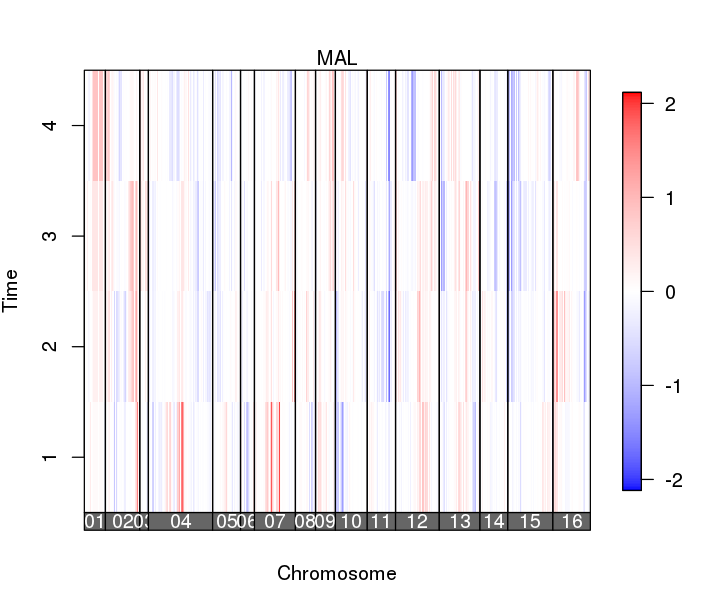

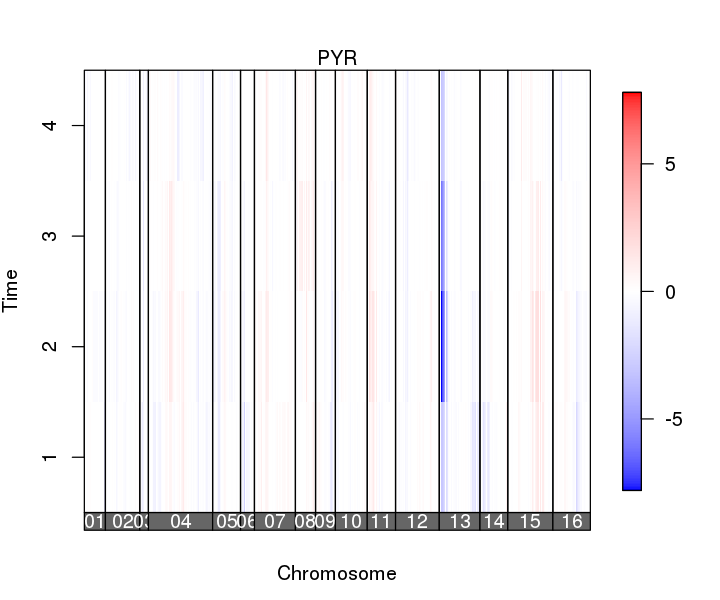

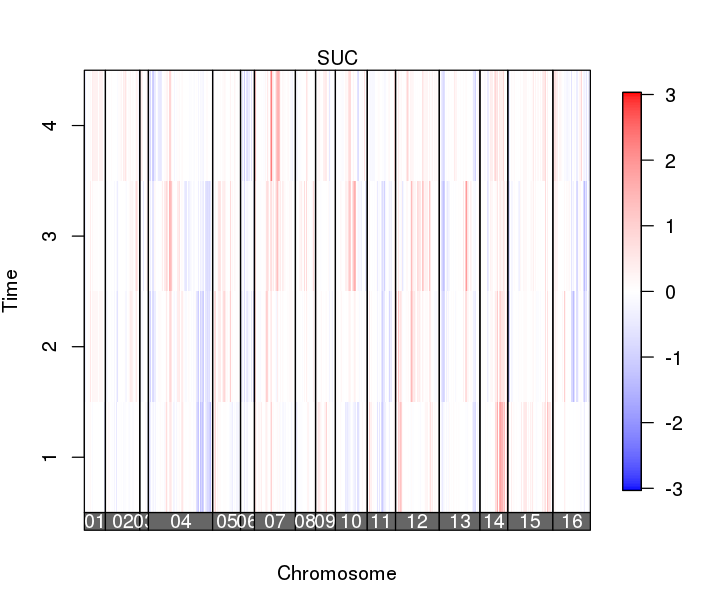

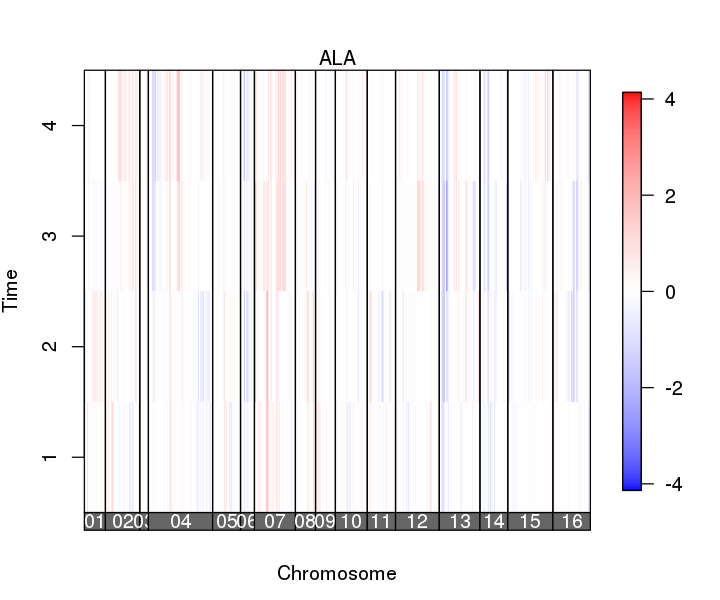

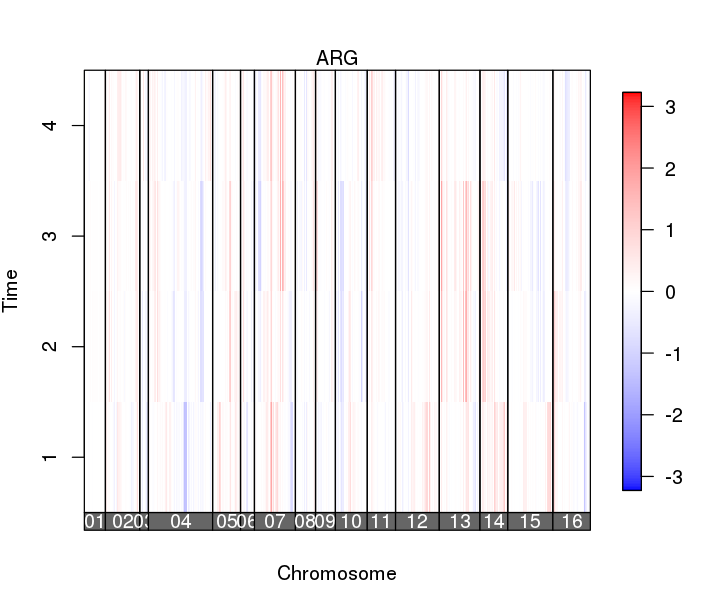

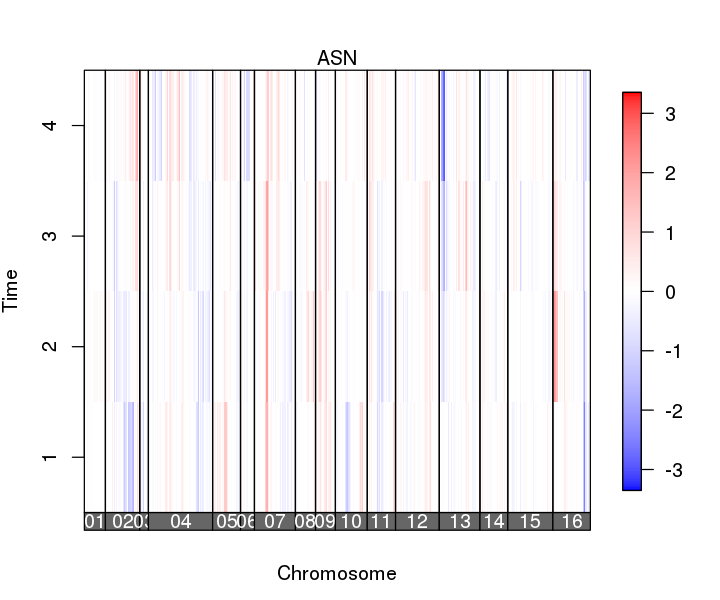

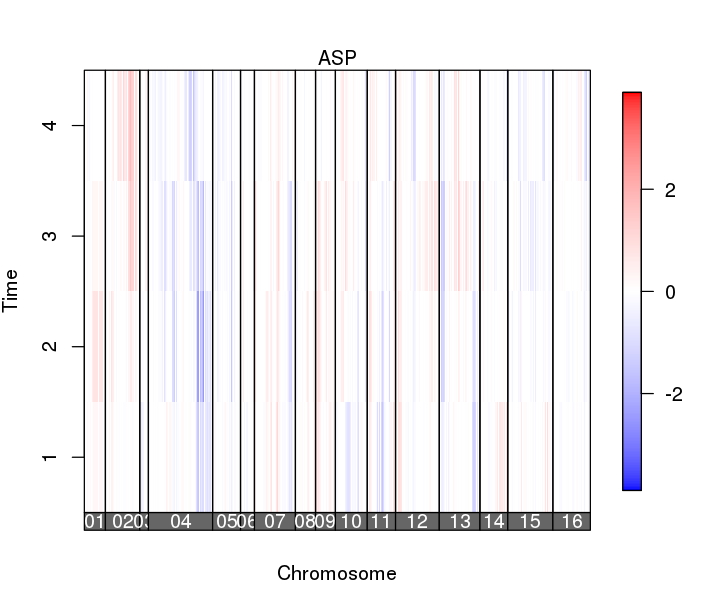

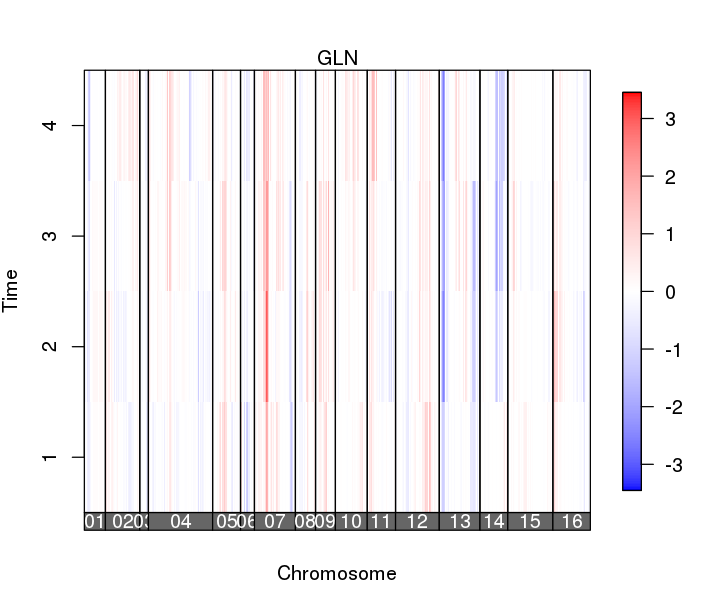

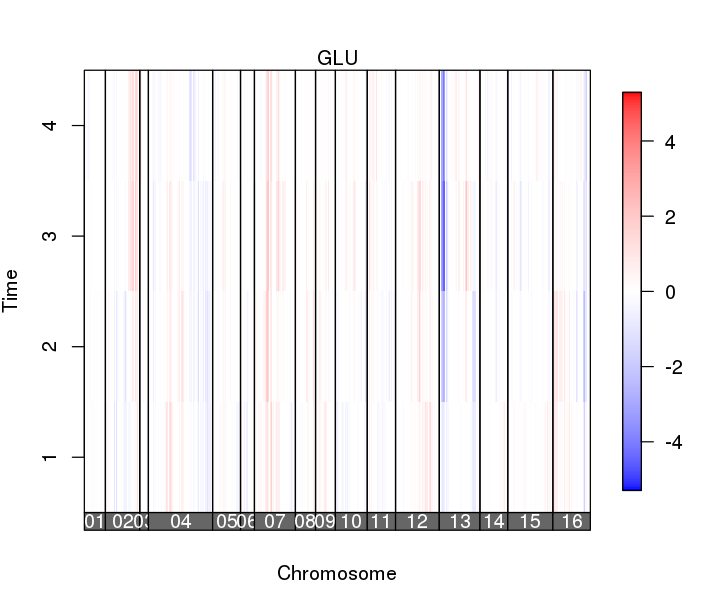

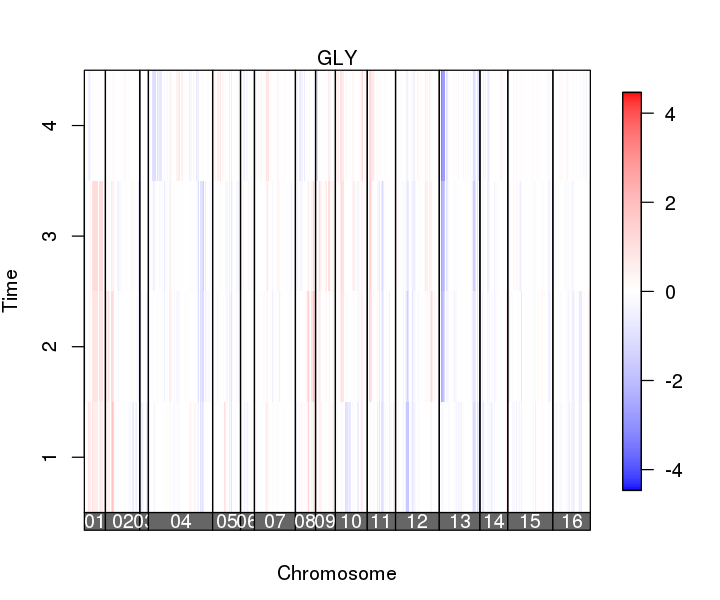

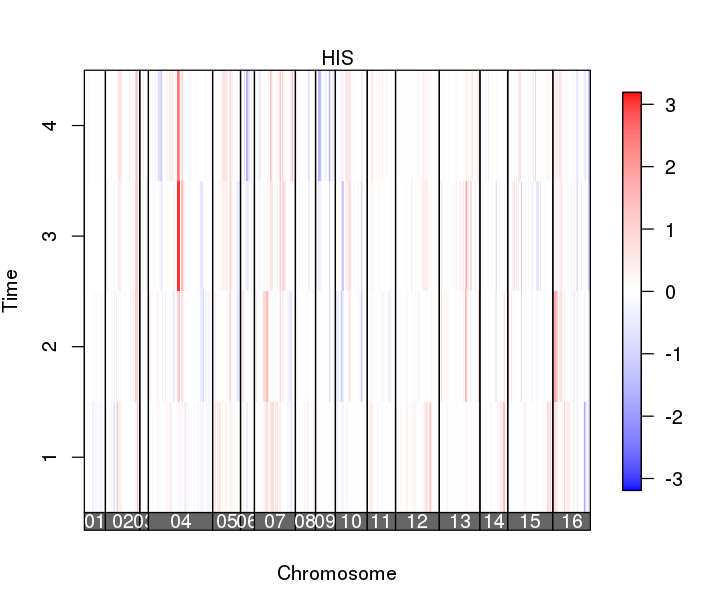

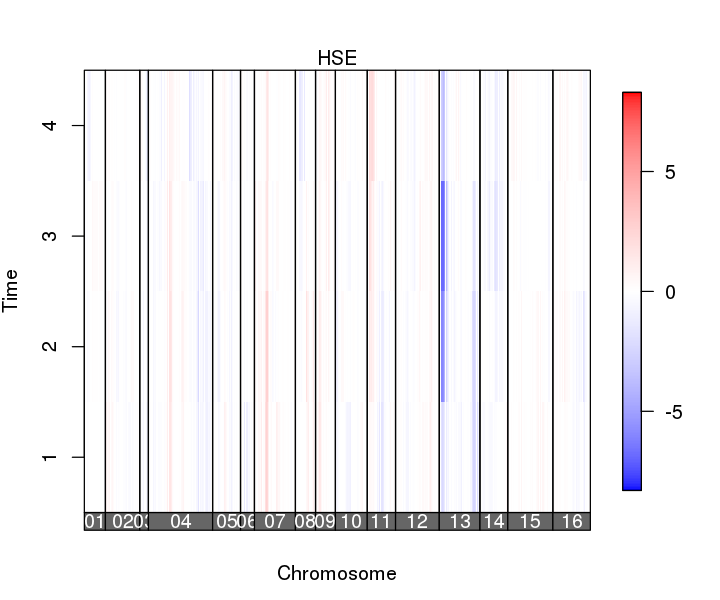

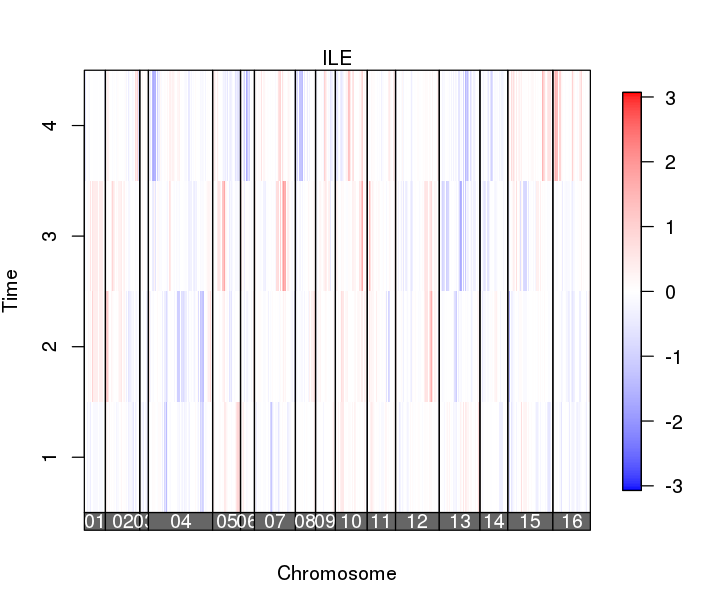

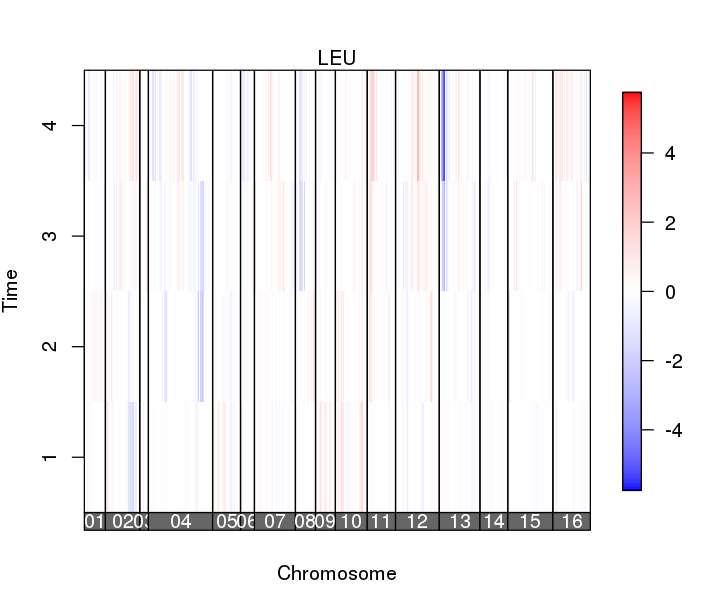

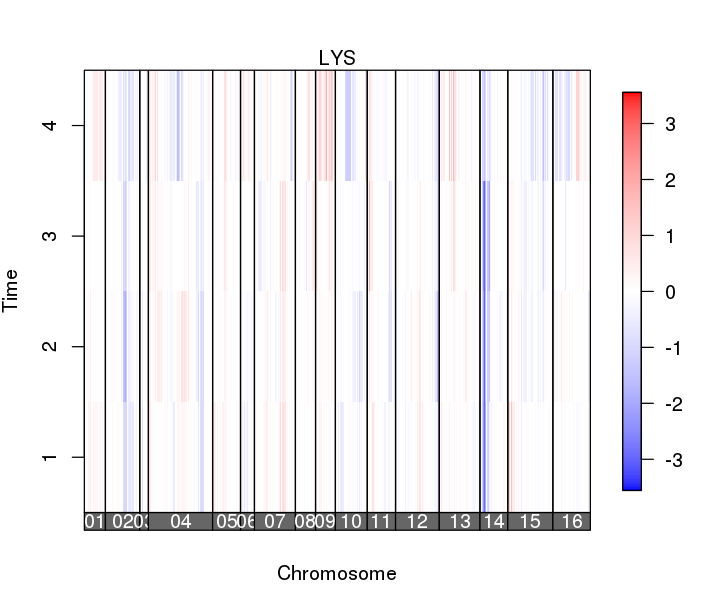

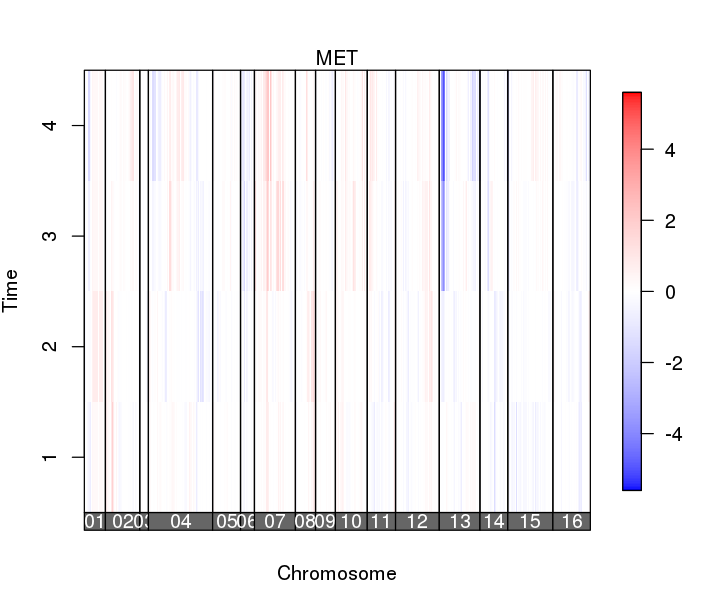

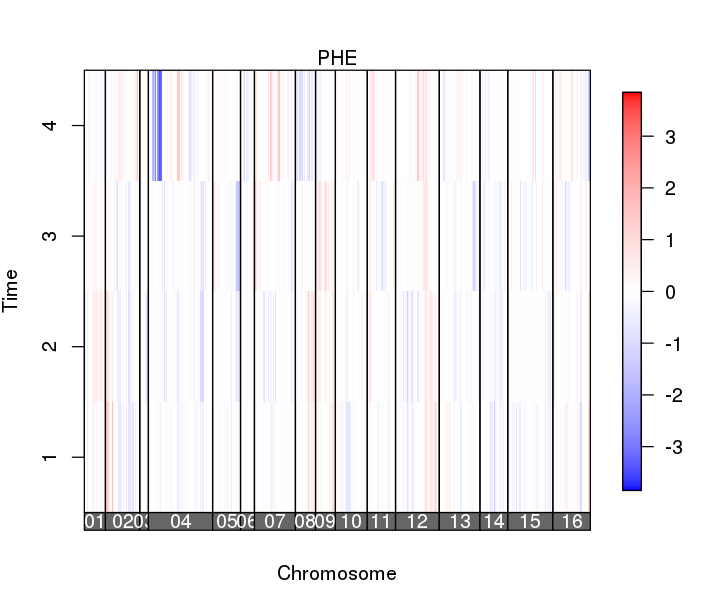

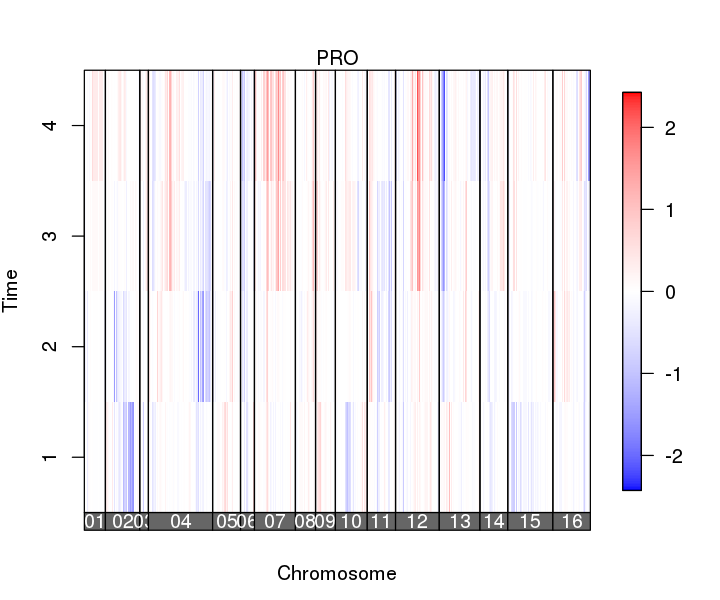

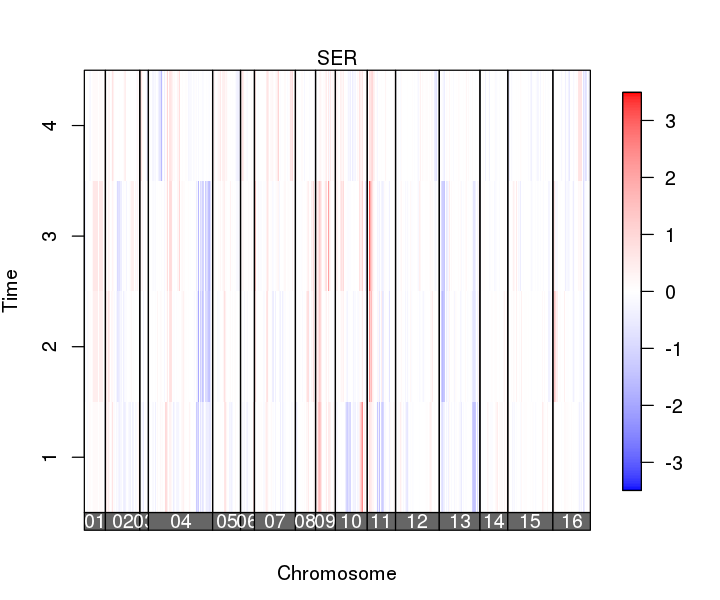

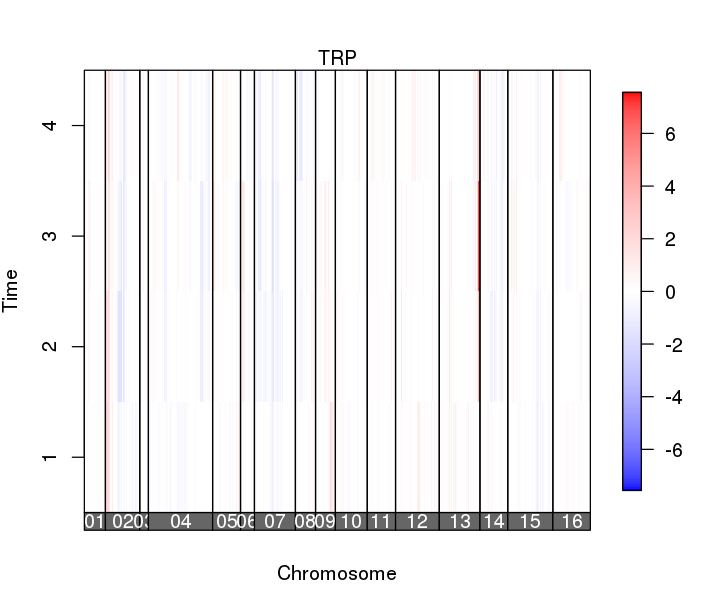

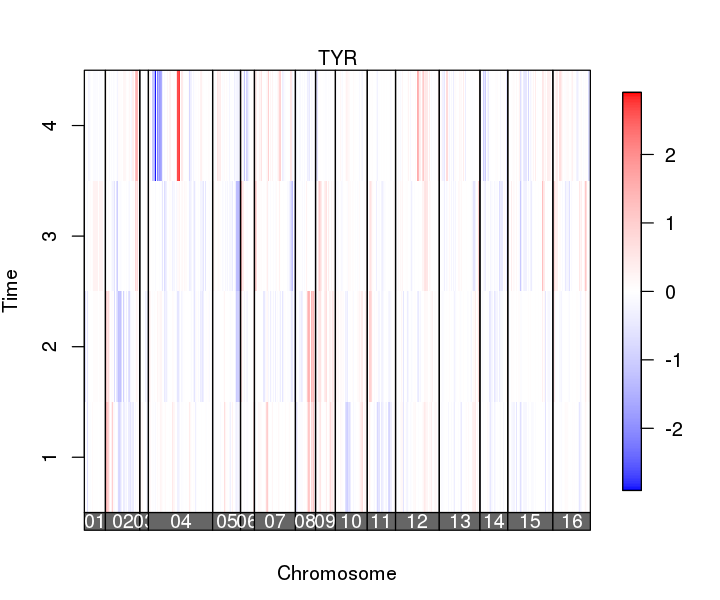

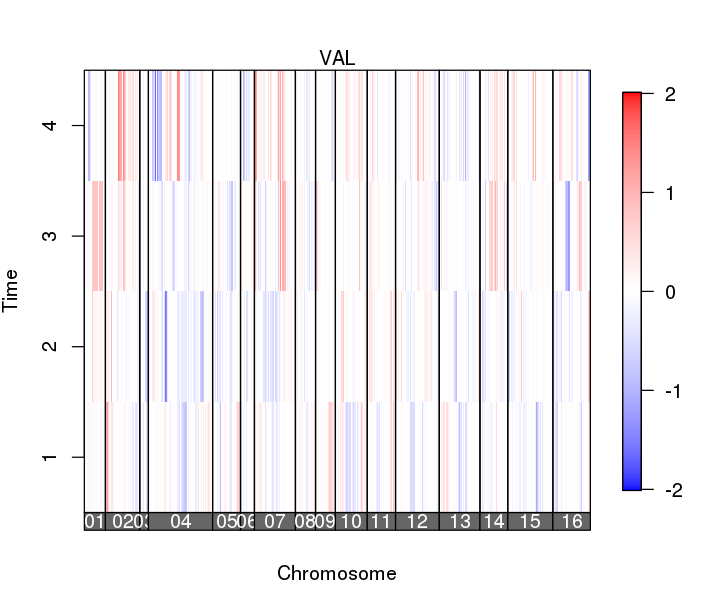

In [61]:
for (i in 1:length(mQTLs_funqtl_raw)) {
            try({
                plotlod(mQTLs_funqtl_raw[[i]]$qtls, mQTLs_funqtl_raw[[i]]$eff, 
                        mQTLs_funqtl_raw[[i]]$pcols, gap=25, ylab="Time")
                mtext(names(mQTLs_funqtl_raw)[i], side = 3)
            })
}

In [ ]:
# save plots
plot = T
if (plot) {
    # effect plots
    pdf("/g/steinmetz/brooks/genphen/metabolome/plots/mQTL_raw/effects.pdf")
        for (i in 1:length(mQTLs_funqtl_raw)) {
            try({
                plotlod(mQTLs_funqtl_raw[[i]]$qtls, mQTLs_funqtl_raw[[i]]$eff, mQTLs_funqtl_raw[[i]]$pcols, gap=25, ylab="Time")
                mtext(names(mQTLs_funqtl_raw)[i], side = 3)
            })
        }
    dev.off()

    # effect plots: jpeg
    for (i in 1:length(mQTLs_funqtl_raw)) {
        try({
            jpeg(paste("/g/steinmetz/brooks/genphen/metabolome/plots/mQTL_raw/effects",names(mQTLs_funqtl_raw)[i],".jpeg",sep=""))
                plotlod(mQTLs_funqtl_raw[[i]]$qtls, mQTLs_funqtl_raw[[i]]$eff, mQTLs_funqtl_raw[[i]]$pcols, gap=25, ylab="Time")
                mtext(names(mQTLs_funqtl_raw)[i], side = 3)
            dev.off()
        })
    }

    m_slod = max(as.numeric(unlist(lapply(seq(1:length(mQTLs_funqtl_raw)),
                                          function(i){try(max(mQTLs_funqtl_raw[[i]]$qtls_alt[,'slod']))}))), na.rm = T)
    m_mlod = max(as.numeric(unlist(lapply(seq(1:length(mQTLs_funqtl_raw)),
                                          function(i){try(max(mQTLs_funqtl_raw[[i]]$qtls_alt[,'mlod']))}))), na.rm = T)

    # lod plots
    pdf("/g/steinmetz/brooks/genphen/metabolome/plots/mQTL_raw/lods.pdf")
        for (i in 1:length(mQTLs_funqtl_raw)) {
            try({
                par(mfrow=c(2,1))
                plot(mQTLs_funqtl_raw[[i]]$qtls_alt, ylim=c(0,m_slod), main=paste(names(mQTLs_funqtl_raw)[i],"SLOD"),bandcol="gray90")
                abline(h=summary(mQTLs_funqtl_raw[[i]]$permout)["5%","slod"], col="red", lty=2)
                abline(h=summary(mQTLs_funqtl_raw[[i]]$permout)["10%","slod"], col="blue", lty=3)
                legend("topright", y.leg[i], c("5% FDR","10% FDR"), lty = c(2, 3), col = c("red","blue"))
                plot(mQTLs_funqtl_raw[[i]]$qtls_alt, lodcolumn=2, ylim=c(0,m_mlod),
                        main=paste(names(mQTLs_funqtl_raw)[i],"MLOD"), bandcol="gray90")
                abline(h=summary(mQTLs_funqtl_raw[[i]]$permout)["5%","mlod"], col="red", lty=2)
                abline(h=summary(mQTLs_funqtl_raw[[i]]$permout)["10%","mlod"], col="blue", lty=3)
            })
        }
    dev.off()

    # lod plots: jpeg
    for (i in 1:length(mQTLs_funqtl_raw)) {
        jpeg(paste("/g/steinmetz/brooks/genphen/metabolome/plots/mQTL_raw/lods",names(mQTLs_funqtl_raw)[i],".jpeg",sep=""))
            try({
                par(mfrow=c(2,1))
                plot(mQTLs_funqtl_raw[[i]]$qtls_alt, ylim=c(0,m_slod), main=paste(names(mQTLs_funqtl_raw)[i],"SLOD"),bandcol="gray90")
                abline(h=summary(mQTLs_funqtl_raw[[i]]$permout)["5%","slod"], col="red", lty=2)
                abline(h=summary(mQTLs_funqtl_raw[[i]]$permout)["10%","slod"], col="blue", lty=3)
                legend("topright", y.leg[i], c("5% FDR","10% FDR"), lty = c(2, 3), col = c("red","blue"))
                plot(mQTLs_funqtl_raw[[i]]$qtls_alt, lodcolumn=2, ylim=c(0,m_mlod),
                        main=paste(names(mQTLs_funqtl_raw)[i],"MLOD"), bandcol="gray90")
                abline(h=summary(mQTLs_funqtl_raw[[i]]$permout)["5%","mlod"], col="red", lty=2)
                abline(h=summary(mQTLs_funqtl_raw[[i]]$permout)["10%","mlod"], col="blue", lty=3)
            })
        dev.off()
    }
}